<img src = "https://images2.imgbox.com/c1/79/4H1V1tSO_o.png" width="1200">

# ALGORITMOS DE REGRESSÃO LINEAR & VALIDAÇÃO
---
Agora é hora de colocar a mão na massa!

O que vamos ver:

- Regressão linear

- Regressão linear múltipla

- Gradiente descendente

- Regressão Polinomial

- Underfitting e Overfitting

Nesse material iremos aplicar o que aprendemos sobre regressão linear para fazer a previsão do preço de casas em Boston. Esse é um dataset clássico para estudos e que a biblioteca do scikit-learn já traz pra gente.

Para ficar mais claro quais bibliotecas estamos usando em cada parte, ao invés de importar todas logo no começo vou trazendo elas conforme forem necessárias para o nosso código.

Primeiro vamos carregar o pandas e o dataset que vamos trabalhar.

In [1]:
import pandas as pd
from sklearn.datasets import load_boston

dataset = load_boston()
variaveis = pd.DataFrame(dataset.data, columns=dataset.feature_names)
preco = pd.Series(dataset.target, name='MEDV')
df = pd.concat([variaveis, preco], axis=1)

Com o comando .DESCR podemos ver a descrição das variáveis.

In [2]:
print(dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Vamos dar uma olhada nas primeiras linhas dos dados e checar se existem dados nulos ou não numéricos.

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


Nesse dataset os dados já estão bem tratados então vamos desenhar algumas visualizações para entender o comportamento básico das nossas variáveis.

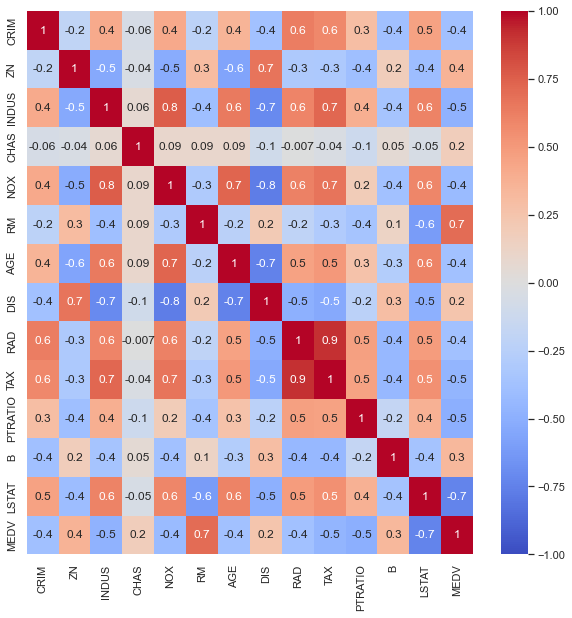

In [6]:
import seaborn as sns

sns.set(rc={'figure.figsize': (10, 10)})
sns.heatmap(df.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm');

As variáveis ‘LSTAT’ e ‘RM’ mostraram uma alta correlação com ‘MEDV’ que é a nossa variável alvo. Vamos ver essa relação mais de perto.



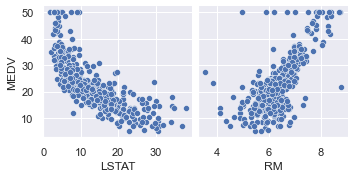

In [7]:
sns.pairplot(y_vars='MEDV', x_vars=['LSTAT', 'RM'], data=df);

Antes de começar a fazer nossas regressões vamos dividir o dataset em duas partes.

## Treino/Teste

Saber se o seu modelo é generalizável é uma etapa muito importante no processo de modelagem.

Dividir os seus dados em duas partes permite que você treine o seu modelo em um conjunto de dados e teste o seu modelo com dados que ele nunca viu, comparando a performance do modelo nos dois diferentes conjuntos podemos ver o modelo está conseguindo extrapolar a “previsão” para novos dados.

Para fazer essa divisão também temos uma biblioteca que já faz isso pra gente.

Essa função irá dividir nossas variáveis explicativas e independente na proporção que passarmos pelo parâmetro ‘test_size’. Nesse caso estamos usando 0.2, ou seja, usaremos 80% dos nossos para treino e 20% para teste.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(variaveis, preco, test_size=0.2, random_state=42)

## Regressão Linear Simples

Vamos começar fazendo uma regressão linear simples, ou seja, usaremos apenas uma variável para traçar uma reta que irá “prever” o preço da casa.

Existem diversas bibliotecas que podemos usar para fazer a regressão linear, inclusive podemos até construir uma do zero, vamos ver as duas mais usadas.

## Statsmodel

In [9]:
import statsmodels.formula.api as sm

reg_linear1 = sm.ols(formula='MEDV~LSTAT', data=df.iloc[X_train.index,:]).fit()
reg_linear1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     476.3
Date:                Wed, 23 Mar 2022   Prob (F-statistic):           3.20e-70
Time:                        19:00:24   Log-Likelihood:                -1317.2
No. Observations:                 404   AIC:                             2638.
Df Residuals:                     402   BIC:                             2646.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.8369      0.635     54.860      0.000      33.589      36.085
LSTAT         -0.9665      0.044    -21.825      0.000      -1.054      -0.879
==============================================================================
Omnibus:                       95.490   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.482
Skew:                           1.324   Prob(JB):                     7.85e-39
Kurtosis:                       4.846   Cond. No.                         29.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A biblioteca do Statsmodel nos traz esse sumário com várias informações que podemos usar para avaliar nosso modelo.

## Revisão rápida

**Coeficientes:** O coeficiente indica que para cada unidade adicional em LSTAT você pode esperar que o MEDV decresça, em média, em 0.96 ($1000).

**R²:** O quanto o seu modelo consegue explicar a variação da variável dependente.

**P-valor:** Neste sumário cada linha traz o teste para uma hipótese nula de que o coeficiente é igual a 0, ou seja, de que a variável não explica a variável dependente. Então estamos em busca de um p-valor menor que 0.05, para que nós rejeitemos a hipótese nula.

**Intercepto:** É o valor esperado para a regressão caso todas as variáveis explicativas sejam 0, ou seja, onde a reta da regressão linear corta o eixo y.

**Durbin-Watson:** Teste estatístico realizado para detectar autocorrelação nos resíduos da regressão. Valores vão de 0 a 4, 0 a 2 mostra uma autocorrelação positiva, 2 a 4 uma autocorrelação negativa, e exatamente 2 mostra que não existe autocorrelação.

## Scikit-learn

É possível fazer essa mesma regressão usando a biblioteca do scikit-learn.

In [12]:
from sklearn.linear_model import LinearRegression

rls = LinearRegression()
rls.fit(X_train[['LSTAT']], y_train)

LinearRegression()

Aproveitando que temos apenas duas dimensões podemos desenhar um gráfico e ver como é essa reta que criamos para fazer a previsão de preços.

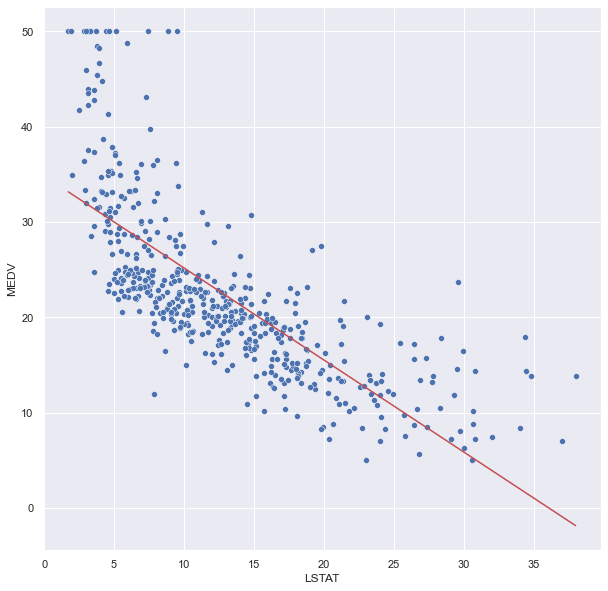

In [13]:
sns.scatterplot(x=df['LSTAT'], y=df['MEDV'])
sns.lineplot(x=df['LSTAT'], y=[rls.coef_[0] * i + rls.intercept_ for i in df['LSTAT']], color='r');

## Métricas

Conforme nós vamos criando e alterando diversos modelos precisamos poder compará-los para saber se estamos indo na direção correta.

**RMSE:** Root-mean-square-error ou a raiz do erro quadrático médio. É o desvio padrão dos resíduos que é a diferença do valor real para o valor predito

**MAE:** Mean Absolute Error ou o Erro médio absoluto. Parecido com RMSE, mas ao invés de elevar o resíduo o quadrado, soma-se o módulo.

**R² e R²-ajustado:** Já vimos que o R² diz o quanto nosso modelo explica a variação da nossa variável dependente. O R²-ajustado vai levar em conta também a quantidade de variáveis independentes que o modelo contém, então ele vai penalizar quando tiver variáveis que não contribuem para o modelo.

Voltando para a parte prática, vamos importar as funções que fazem o cálculo dessas métricas e criar uma função para passar esses parâmetros e já imprimir o resultado.

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

def imprimir_metricas(model, X_train, X_test, y_train, y_test, name):
    train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, train_pred)**0.5
    r2_train = r2_score(y_train, train_pred)

    test_pred = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, test_pred)**0.5
    r2_test = r2_score(y_test, test_pred)

    print(f'''***{name}***
    treino
    RMSE: {round(rmse_train, 2)}
    R2: {round(r2_train, 2)}\n
    teste:
    RMSR: {round(rmse_test, 2)}
    R2: {round(r2_test, 2)}''')

In [15]:
imprimir_metricas(rls, X_train[['LSTAT']], X_test[['LSTAT']], y_train, y_test, 'Regressão Linear Simples')

***Regressão Linear Simples***
    treino
    RMSE: 6.31
    R2: 0.54

    teste:
    RMSR: 5.79
    R2: 0.54


## Regressão linear múltipla

A lógica da regressão linear múltipla é exatamente a mesma da regressão linear simples, a única diferença é a quantidade de variáveis. Vamos adicionar a variável ‘**RM**’.

In [26]:
rlm = LinearRegression()
rlm.fit(X_train[['LSTAT', 'RM']], y_train)

imprimir_metricas(rlm, X_train[['LSTAT', 'RM']], X_test[['LSTAT', 'RM']], y_train, y_test, 'Regressão Linear Simples')

***Regressão Linear Simples***
    treino
    RMSE: 5.51
    R2: 0.65

    teste:
    RMSR: 5.59
    R2: 0.57


## Gradiente descendente

As regressões que rodamos até agora usaram o método dos mínimos quadrados ordinários (OLS) mas também é possível usar outro tipo de resolução que é o Gradiente descendente.

A biblioteca do scikit-learn também traz esse método.

Faremos com apenas uma variável para poder comparar graficamente com a regressão anterior.

In [27]:
from sklearn.linear_model import SGDRegressor

sgdr = SGDRegressor()
sgdr.fit(X_train[['LSTAT']], y_train)

imprimir_metricas(sgdr, X_train[['LSTAT']], X_test[['LSTAT']], y_train, y_test, 'Regressão Linear Simples')

***Regressão Linear Simples***
    treino
    RMSE: 6.32
    R2: 0.54

    teste:
    RMSR: 5.79
    R2: 0.54


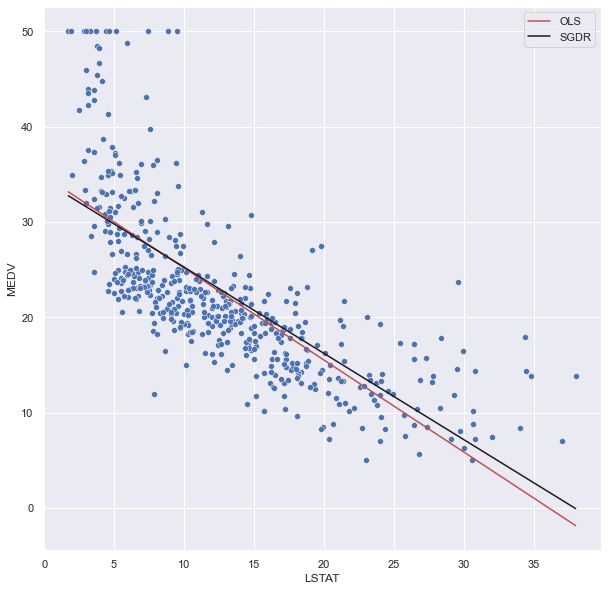

In [28]:
chart = sns.scatterplot(x=df['LSTAT'], y=df['MEDV'])
sns.lineplot(x=df['LSTAT'], y=[rls.coef_[0] * i + rls.intercept_ for i in df['LSTAT']], color='r')
sns.lineplot(x=df['LSTAT'], y=[sgdr.coef_[0] * i + sgdr.intercept_[0] for i in df['LSTAT']], color='k')
chart.legend(['OLS', 'SGDR']);

## Regressão Polinomial

Por vezes uma simples reta não é a melhor representação de um conjunto de dados. Apesar de visualmente a regressão polinomial não ser uma reta ela é considerada como um caso de regressão linear.

Vamos ver na prática:

In [40]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train[['LSTAT']])

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

imprimir_metricas(poly_model, 
                  poly_features.fit_transform(X_train[['LSTAT']]), 
                  poly_features.fit_transform(X_test[['LSTAT']]), y_train, y_test, 'Polinomial')

***Polinomial***
    treino
    RMSE: 5.46
    R2: 0.66

    teste:
    RMSR: 5.03
    R2: 0.66


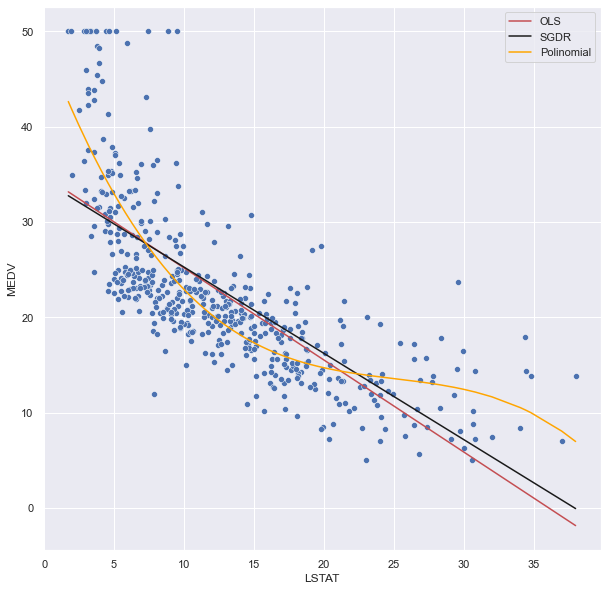

In [50]:
chart = sns.scatterplot(x=df['LSTAT'], y=df['MEDV'])
sns.lineplot(x=df['LSTAT'], y=[rls.coef_[0] * i + rls.intercept_ for i in df['LSTAT']], color='r')
sns.lineplot(x=df['LSTAT'], y=[sgdr.coef_[0] * i + sgdr.intercept_[0] for i in df['LSTAT']], color='k')
sns.lineplot(x=df['LSTAT'], y=poly_model.predict(poly_features.fit_transform(df[['LSTAT']])), color='orange')
chart.legend(['OLS', 'SGDR', 'Polinomial']);

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x=df['LSTAT'], y=[poly_model.predict(poly_features.fit_transform(df['LSTAT']))], color='orange')

Perceberam que aos poucos estamos adicionando complexidade ao nosso modelo? Quanto mais variáveis independentes adicionamos mais complexo fica o modelo. Se aumentarmos os graus da regressão polinomial também estaremos aumentando a complexidade do modelo.

Vamos ver o que acontece com um modelo bem complexo.

In [33]:
poly_features = PolynomialFeatures(degree=4)
X_train_poly = poly_features.fit_transform(X_train[['LSTAT', 'RM', 'PTRATIO']])

poly_model2 = LinearRegression()
poly_model2.fit(X_train_poly, y_train)

imprimir_metricas(poly_model2, 
                  poly_features.fit_transform(X_train[['LSTAT', 'RM', 'PTRATIO']]), 
                  poly_features.fit_transform(X_test[['LSTAT', 'RM', 'PTRATIO']]), y_train, y_test, 'Polinomial bem complexo')

***Polinomial bem complexo***
    treino
    RMSE: 3.66
    R2: 0.85

    teste:
    RMSR: 5.57
    R2: 0.58


## Overfitting

Olha que interessante, colocando apenas mais duas variáveis e aumentando um grau na regressão polinomial podemos ver uma diferença grande entre os resultados do Treino e do Teste.

Podemos imaginar que nosso modelo ficou ‘viciado’ nos dados de treino e não consegue generalizar e acaba perdendo poder preditivo. Chamamos isso de Overfitting.

Na perspectiva oposta, quando nosso modelo ainda não está conseguindo “explicar” a variável independente nem no treino, podemos dizer que nosso modelo está em Underfitting.

Veja na imagem abaixo:

<img src = "https://firebasestorage.googleapis.com/v0/b/images-tera-platform/o/public%2Fmedia%2F1631552834819-fig16.PNG?alt=media" width="800">

## Resumo

Esse padrão que você observou é o que você fará para outros tipos de modelo também, então deixo abaixo um guia rápido para que você possa usar como checklist.

- Importar bibliotecas

- Dividir o dataset em Treino e teste

- Instanciar o modelo em uma variável

- Treinar o modelo .fit()

- Rodar o modelo .predict() na base de treino e teste

- Analisar Overfitting/underfitting

- Comparar com outros modelos (se tiver)


## Referências

Statsmodel: https://www.statsmodels.org/stable/regression.html

Scikit-learn: https://scikit-learn.org/stable/modules/linear_model.html

Overfitting: http://scott.fortmann-roe.com/docs/BiasVariance.html

Para reforçar a parte teórica de regressão linear consultem os materiais anteriores sobre o tema.